Based on Kaggle python3 docker image.
For more explaintation:
https://www.kaggle.com/junxiangji/lstm-sentiment-analysis-keras/edit 


# TODO - What do we learn from the work

This can be further tweaked by 
* remove @someone in the tweets.
* remove stop words.
* use word2vec during embeding.
* change the LSTM to Dense and change the parameter.
* give emoticons more importance.
* Boosting - Observed that having an extra `neutral` category would greatly decrease `positive` acc (much worse than randomly perdition which should have 30% acc) and predition for neutral is as bad as random perdiction. We need to only train the model for `positive` and `neutral` and then ensamble them togather. 
* also considering that the train accuracy is high and has huge diverse with test result, we are having great overfit problem here.
* Considering that positive has 2000 tweets at 10% acc and netural has 3000 tweets at 36% acc, we might conclude that number of cropus is top 1 factor which affects the accuracy. ** so we should consider to give more data to training when split the data to trian and test.(currently .33 suggest to .10) **
* data set is highly imbalanced that would make the model prone to perdict everything as negitive (in every mini batch). Try to duplicate the _neutral_ by 2 times and _negtive_ by 4 times. (This may not need if we use above boosting method.)
* read more paper regarding this LSTM model.


In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [32]:
data1 = pd.read_csv('./data/Sentiment.csv')
# Keeping only the neccessary columns
data = data1[['text','sentiment']]

In [33]:
%matplotlib inline
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
data[0:9]
# data.dtypes

# data[data.sentiment.isnull()]

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive
5,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",Positive
6,RT @warriorwoman91: I liked her and was happy ...,Negative
7,Going on #MSNBC Live with @ThomasARoberts arou...,Neutral
8,Deer in the headlights RT @lizzwinstead: Ben C...,Negative


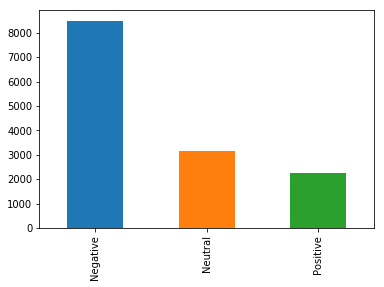

In [34]:
data.sentiment.value_counts().plot(kind="bar")

In [35]:
# data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

# Why size and shape are not same?
print(data.size)
print(data.shape)
#print(data.tail)
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 4000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)

X = tokenizer.texts_to_sequences(data['text'].values)
#tokenizer.word_counts
# tokenizer.word_index # index started from 1 not 0.
X[0:2] # type is list


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


4472
16986
27742
(13871, 2)


[[2541, 52, 78, 341, 456, 22, 2, 420, 365, 95, 29, 51, 1039, 1],
 [351,
  125,
  1954,
  2,
  597,
  1,
  29,
  51,
  228,
  35,
  198,
  5,
  175,
  1417,
  10,
  1577,
  1356,
  847]]

In [36]:
 # type is array and we prefixed with zeros. This should be masked in model
X = pad_sequences(X)

print(X.shape)
X[0:2]

(13871, 29)


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 2541,   52,   78,  341,  456,   22,    2,
         420,  365,   95,   29,   51, 1039,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         351,  125, 1954,    2,  597,    1,   29,   51,  228,   35,  198,
           5,  175, 1417,   10, 1577, 1356,  847]], dtype=int32)

JIM: can remove **stop words**

For the following Embeding layer. The input is the sequence of words, and the out put will has one more dimension.
Which is because now one word previously is represented as a number now become a vector (word embeding)

Ref
https://stackoverflow.com/questions/46155868/keras-embedding-layer

https://keras.io/layers/embeddings/

https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [37]:
embed_dim = 128
lstm_out = 196

model = Sequential()

# TODO: consider using mask_zero=True

model.add(Embedding(max_fatures, embed_dim,mask_zero="Ture", input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 29, 128)           512000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 29, 128)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 392)               509600    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1179      
Total params: 1,022,779
Trainable params: 1,022,779
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
Y = pd.get_dummies(data['sentiment']).values

# negetive, neutral, pos
Y

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]], dtype=uint8)

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(11096, 29) (11096, 3)
(2775, 29) (2775, 3)


# Train

In [40]:
batch_size = 42
model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10
 - 63s - loss: 0.8102 - acc: 0.6506
Epoch 2/10
 - 56s - loss: 0.6593 - acc: 0.7240
Epoch 3/10
 - 59s - loss: 0.5808 - acc: 0.7604
Epoch 4/10
 - 61s - loss: 0.5279 - acc: 0.7807
Epoch 5/10
 - 59s - loss: 0.4835 - acc: 0.8055
Epoch 6/10
 - 55s - loss: 0.4404 - acc: 0.8235
Epoch 7/10
 - 66s - loss: 0.4004 - acc: 0.8394
Epoch 8/10
 - 69s - loss: 0.3722 - acc: 0.8503
Epoch 9/10
 - 62s - loss: 0.3473 - acc: 0.8683
Epoch 10/10
 - 60s - loss: 0.3274 - acc: 0.8689


# Score
## Pure LSTM
Epoch 10/100
 - 18s - loss: 0.4684 - acc: 0.8115
 
 

In [41]:

model.save('whole_model_10_round_biLSTM.h5')

In [43]:
from keras.models import load_model
model = load_model('whole_model_10_round_biLSTM.h5')

# Validation

In [44]:
validation_size = 1500

X_validate = X_test[-validation_size:]
print(X_validate.shape)
Y_validate = Y_test[-validation_size:]
print(Y_validate.shape)
X_test = X_test[:-validation_size]
print(X_test.shape)
Y_test = Y_test[:-validation_size]
print(Y_test.shape)

score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

(1500, 29)
(1500, 3)
(1275, 29)
(1275, 3)
score: 1.11
acc: 0.66


In [45]:
pos_cnt, neg_cnt, neu_cnt, pos_correct, neu_correct, neg_correct = 0, 0, 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
#         print("Y_validate[x] - ", Y_validate[x], ", argmax - ", np.argmax(Y_validate[x]) )
        if np.argmax(Y_validate[x]) == 0: # argmax reture the _index_: 0 - neg, 1 - neu, 2 - positive 
            neg_correct += 1
        elif np.argmax(Y_validate[x]) == 1:
            neu_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    if np.argmax(Y_validate[x]) == 1:
        neu_cnt += 1
    else:
        pos_cnt += 1

print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neu_acc", neu_correct/neu_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")


pos_acc 10.179640718562874 %
neu_acc 40.78549848942598 %
neg_acc 80.08519701810437 %


# Score
## Pure LSTM
pos_acc 10.129870129870131 %
neu_acc 36.811594202898554 %
neg_acc 79.27232635060639 %
## Bi LSTM
pos_acc 10.179640718562874 %
neu_acc 40.78549848942598 %
neg_acc 80.08519701810437 %


# Prediction

In [50]:
# twt = ['Meetings: Because none of us is as dumb as all of us.']
twt = ['good']
# twt = ['no good']

#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=29, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]

print(model.predict_proba(twt,batch_size=1,verbose = 2))

if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("neutral")
elif (np.argmax(sentiment) == 2):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0 146]]
[[0.01488806 0.04913476 0.93597716]]
positive
